# Chapter10 价值溢价

价值溢价一般由账面市值比来衡量，一般相对账面价值，价格偏低的股票被称作价值股（B/M较大的股票），而反过来，相对于账面价值市场价格偏高的股票为成长股（B/M较小的股票）。Fama和French的经典文章中，论证了账面市值比这个因子的有效性，于是在本章，我们重点讨论账面市值比（BM）于股票期望收益率的正相关关系。

对于BM与收益的正相关关系的解释目前仍未统一，接下来列举两种主流观点。

第一种是Fama和French提出的基于风险的解释，他们认为：由于一个高BM的公司有更高的股票收益率是由于其对定价风险因素的暴露程度更高。

第二种是以Lakonishok和La Porta为首的一群学者提出的基于投资者行为（行为金融学）的解释，他们认为：与价值投资相关的收益是由于非理性投资者对未来增长的错误预期与错误定价带来的。

下面我们将对价值溢价进行中国A股市场的实证研究，因子值时间从2000年1月开始至2019年12月，月频率。接着探讨了不同变量间的相关系数，BM因子的持续性，单变量、独立双变量与非独立双变量投资组合分析，FM回归分析以及HML因子从2000年以来的累积超额收益与复合超额收益

## 10.1计算BM与其他需要数据处理

BM = BE/ME

ln BM = ln（BM）

其中BE为上市公司的账面价值，具体计算为：账面价值 = 所有者权益+递延所得税资产-递延所得税负债-优先股。ME即为每个月末市场流通市值。流通市值计算方法第9章已经提过（流通股数*股票价格）。由于我们计算的是月度的因子值，有一个会计数据频率无法匹配的问题。每个月BM中的BE取的是当月可获取的最新数据，也就是每年4月之前，所有的BE取的是前年的会计数据，而4月之后取的是去年的会计数据。

而还有一些其他需要用到的数据，MktCap也是流通市值，由于中国A股一家公司只能有一只股票，于是实证中MktCap和ME是同一个值。beta用的是第八章中日度数据计算的年度跨度的β12M，与年度更新的会计数据匹配。

Size = ln（MktCap）

In [52]:
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.ticker as mtick
from scipy.stats.mstats import winsorize
##############################################数据基本处理
##处理年度收益与年度流动市值
monthly = pd.read_csv('monthly.csv')
monthly['mktcap'] = monthly['mktcap']/100000
monthly = monthly[(monthly['type']!=2)&(monthly['type']!=8)]
monthly['date'] = pd.to_datetime(monthly['date'])
monthly['month'] = monthly['date'].dt.month
monthly['year'] = monthly['date'].dt.year
monthly = monthly[monthly['year']>=2000]
#处理超额收益
mkt_rf_factor = pd.read_csv('fivefactor_monthly.csv')
mkt_rf_factor['year'] = mkt_rf_factor['date']//100
mkt_rf_factor['month'] = mkt_rf_factor['date']%100
mkt_rf_factor = mkt_rf_factor[(mkt_rf_factor['year']>=2000)&(mkt_rf_factor['year']<=2019)]
del mkt_rf_factor['date']
monthly = pd.merge(monthly,mkt_rf_factor,on=['year','month'])
monthly['rt'] = monthly['rt'] - monthly['rf']
#设置月份定义
monthly['month_num'] = (monthly['year']-2000)*12+monthly['month']
#展开
mktcap = pd.pivot(monthly,index='code',columns='month_num',values='mktcap')
monthly_rt = pd.pivot(monthly,index='code',columns='month_num',values='rt')
monthly_rt = monthly_rt*100
monthly_rt.columns = monthly_rt.columns-1
monthly_rt = monthly_rt.loc[:,1:]
##处理账面价值
balance_sheet = pd.read_csv('balance sheet.csv')
balance_sheet = balance_sheet[balance_sheet['type']=='A']
balance_sheet['date'] = pd.to_datetime(balance_sheet['date'])
balance_sheet['year'] = balance_sheet['date'].dt.year
balance_sheet['month'] = balance_sheet['date'].dt.month
balance_sheet = balance_sheet[balance_sheet['month']==12]
balance_sheet.loc[balance_sheet['defer assets'].isna(),'defer assets'] = 0
balance_sheet.loc[balance_sheet['defer debut'].isna(),'defer debut'] = 0
balance_sheet.loc[balance_sheet['prior stock'].isna(),'prior stock'] = 0
balance_sheet['be'] = balance_sheet['equity']+balance_sheet['defer assets']-balance_sheet['defer debut']-balance_sheet['prior stock']
be = pd.pivot(balance_sheet,index='code',columns='year',values='be')
be[2019] = be[2018]
be = be/100000000
##bm
def bm_calculate(BE,ME):
    BM = pd.DataFrame()
    for i in ME.columns:
        year = (i//12)+1999
        if i%12 == 0:
            month = 12
        else:
            month = i%12
            
        if month <= 3:
            bm = BE[year-1]/ME[i]
        else:
            bm = BE[year]/ME[i]
        BM = pd.concat([BM,bm],axis=1)
    BM.columns = ME.columns
    return BM

bm = bm_calculate(be,mktcap)
bm[bm<=0] = np.nan
ln_bm = np.log(bm)
#size
size = np.log(mktcap)
##beta用的是每月以日度收益率计算的一年期beta
beta = pd.read_csv('beta.csv',index_col=0)
beta = beta.loc[:,'37':]
beta.columns = mktcap.columns

## 10.2描述性统计

In [22]:
def bm_statistic(list_of_data,name_of_data):
    X = pd.DataFrame()
    for i in range(len(list_of_data)):
        x = list_of_data[i]
        new = pd.Series([x.mean().mean(),x.std().mean(),x.skew().mean(),x.kurt().mean(),x.min().mean(),x.quantile(.05).mean(),x.quantile(.25).mean(),x.median().mean(),x.quantile(.75).mean(),x.quantile(.95).mean(),x.max().mean(),x.count().mean()],
                         index = ['Mean','SD','Skew','Kurt','Min','5%','25%','Median','75%','95%','Max','n'],name = name_of_data[i])
        X = pd.concat([X,new],axis=1,sort=False)
    X = X.T
    X = X.applymap(lambda x:round(x, 2))
    return X

data_list = [bm,ln_bm,be,mktcap]
name_list = ['BM','ln BM','BE','MktCap']
table1 = bm_statistic(data_list,name_list)
table1['n'] = table1['n'].astype('int')
table1

,Mean,SD,Skew,Kurt,Min,5%,25%,Median,75%,95%,Max,n
BM,0.85,0.96,13.37,388.33,0.01,0.21,0.44,0.68,1.01,1.93,23.30,1874
ln BM,-0.55,0.76,-0.72,4.99,-6.04,-1.74,-0.97,-0.52,-0.09,0.57,3.00,1874
BE,49.66,330.01,18.51,449.43,-30.97,2.00,6.12,12.05,25.27,120.22,8990.36,2059
MktCap,63.84,273.15,13.88,297.05,2.17,6.18,13.69,23.79,46.31,176.47,7842.48,1976


ln BM的处理按照预期大大降低了BM的偏度。

## 10.3相关性

In [23]:
def personcorr_calculator(dataname1,dataname2):
    '''
    计算输入两个变量表格的皮尔森系数
    
    参数
    dataname1，dataname2：变量表格，index为股票代码，columns为期数
    
    输出
    一个值，两个变量的皮尔森系数
    '''
    X = []
    X1 = stats.mstats.winsorize(dataname1,limits=0.005,axis=1)
    X2 = stats.mstats.winsorize(dataname2,limits=0.005,axis=1)
    X1 = pd.DataFrame(X1,index = dataname1.index,columns=dataname1.columns)
    X2 = pd.DataFrame(X2,index = dataname2.index,columns=dataname2.columns)
    if len(dataname1.columns)>=len(dataname2.columns):
        month_list = dataname2.columns
    else:
        month_list = dataname1.columns
    for y in month_list:
        x1 = X1[y]
        x2 = X2[y]
        x = pd.concat([x1,x2],axis=1)
        x = x.dropna(axis=0,how='any')
        person_corr = x.corr().iloc[0,1]
        X.append(person_corr)
    X = pd.Series(X)
    x = X.mean()
    return x

def spearman_calculator(dataname1,dataname2):
    '''
    计算输入两个变量表格的斯皮尔曼系数
    
    参数
    dataname1，dataname2：变量表格，index为股票代码，columns为期数
    
    输出
    一个值，两个变量的斯皮尔曼系数
    '''
    X = []
    X1 = stats.mstats.winsorize(dataname1,limits=0.005,axis=1)
    X2 = stats.mstats.winsorize(dataname2,limits=0.005,axis=1)
    X1 = pd.DataFrame(X1,index = dataname1.index,columns=dataname1.columns)
    X2 = pd.DataFrame(X2,index = dataname2.index,columns=dataname2.columns)
    if len(dataname1.columns)>=len(dataname2.columns):
        month_list = dataname2.columns
    else:
        month_list = dataname1.columns
    for y in month_list:
        x1 = X1[y]
        x2 = X2[y]
        x = pd.concat([x1,x2],axis=1)
        x = x.dropna(axis=0,how='any')
        spearman_corr = x.corr(method = 'spearman').iloc[0,1]
        X.append(spearman_corr)
    X = pd.Series(X)
    x = X.mean()
    return x

def data_in_list(list_of_data,name_of_data):
    '''
    生成变量相关系数的矩阵
    
    输入
    list_of_data：所有参与矩阵计算的变量的list，每个变量df格式同上面函数要求
    name_of_data：变量的名字列表，datalist里变量的顺序和名字顺序要完全对应
    
    输出
    df,上半部分为斯皮尔曼系数下半部分皮尔森系数
    '''
    
    X = pd.DataFrame([],index = name_of_data,columns = name_of_data)
    for i in range(len(list_of_data)):
        for j in range(len(list_of_data)):
            if i<=j:
                X.iloc[i,j] = spearman_calculator(list_of_data[i],list_of_data[j])
            else:
                X.iloc[i,j] = personcorr_calculator(list_of_data[i],list_of_data[j])
    X = X.applymap(lambda x:round(x, 2))
    return X

data_list2 = [bm,ln_bm,beta,size]
name_list2 = ['BM','ln BM','β','Size']
table2 = data_in_list(data_list2,name_list2)            
table2

,BM,ln BM,β,Size
BM,1.00,1.00,0.03,-0.12
ln BM,0.68,1.00,0.03,-0.12
β,-0.04,0.07,1.00,-0.14
Size,-0.01,-0.07,-0.18,1.00


可以看到，相比与其他结果来说，BM和ln BM之间的皮尔森系数较高，而由于BM与ln BM的排序一致，所以在斯皮尔曼系数中，这两个变量与其他变量的相关系数是相同的。但是beta和size是负相关，与美国市场的情况不符合。在验证了并不是beta数据和size本身的问题后，我们认为可能是中国国有企业的情况影响了完全市场经济的美国市场与社会主义特色市场经济的中国市场的差别。

## 10.4 持续性

In [24]:
def Persistence_calculator(df):
    corr = df.corr()
    delay_list = [12,24,36,48,60,120]
    X = pd.DataFrame([],index = df.columns,columns = delay_list)
    for x in range(len(df.columns)):
        for y in range(6):
            if x+delay_list[y] < df.shape[1]:
                X.iloc[x,y] = corr.iloc[x,x+delay_list[y]]
    stats = X.mean()
    return stats

persistence_bm = Persistence_calculator(bm)
persistence_ln = Persistence_calculator(ln_bm)
table3 = pd.concat([persistence_bm,persistence_ln],axis=1,sort=False,keys=['BM','ln BM'])
table3.index.name = 'τ'
table3 = table3.applymap(lambda x:round(x, 3))
table3

,BM,ln BM
τ,,
12,0.821,0.784
24,0.690,0.635
36,0.588,0.532
48,0.526,0.462
60,0.470,0.410
120,0.257,0.241


可以看到BM与ln BM的持续性比前面β要好，也能在一个较长的滞后期中保持超过0.5的自相关系数。然而（按道理来说）比MktCap要差（但实证目前不清楚因为我做这个的时候还没看到MktCap那一章的结果）。原书中美国市场ln BM的持续性比BM普遍要高，所以原书得出的结论是ln BM比起BM要更适合作为衡量风险因子，然而在中国A股市场实证的数据则相反，原始的BM还是更能衡量风险因子。
这个差异目前还未找到合理解释。

## 10.5账面市值比和股票收益的关系

### 10.5.1单变量分组

我们首先用每一期的全市场BM然后将样本分成10组计算每一期的平均市场超额收益，再计算时序平均和进行CAPM调整回归。在保证样本同时有收益数据和BM数据情况下对样本进行分组。

In [25]:
##表格前半部分是断点下其他简单因子数据的统计
def factor_potoforlio(factor,list_of_data,list_of_data_name):
    '''
    输入划分投资组合的因子值和投资组合要进行分类计算的数据，输出统计1-10结果
    
    参数
    factor：因子值表格，index为股票代码，columns为月份编号
    list_of_data:要进行分组合统计的数值，输入格式同上
    list_of_data_name：数值名称，用于最后输出规范结果
    
    输出
    df，index为统计的变量名称，columns为投资组合1到10，值为数值分组后市场时序平均值
    '''
    avg_list = pd.DataFrame()
    for k in range(len(list_of_data)):
        data = list_of_data[k]
        data_name = list_of_data_name[k]
        data_list = pd.DataFrame()
        for i in factor.columns:
            temp_factor = factor[i].dropna()
            temp_data = data[i].dropna()
            x = pd.concat([temp_factor,temp_data],axis=1,sort=False)
            x.columns = [i,data_name]
            x['group'] = pd.qcut(x[i],10,labels=False)
            data_avg_i = x.groupby('group')[data_name].mean()
            data_list = pd.concat([data_list,data_avg_i],axis=1)
        data_list.columns = factor.columns
        data_list = data_list.T
        data_list.columns = range(1,11)
        data_avg = data_list.mean()
        data_avg.name = data_name
        avg_list = pd.concat([avg_list,data_avg],axis=1,sort=False)
    data_count_list = pd.DataFrame()
    for i in factor.columns:
        temp_factor = factor[i].dropna()
        x = pd.qcut(temp_factor,10,labels=False)
        x = pd.concat([temp_factor,x],axis=1,sort=False,keys=['factor','group'])
        data_count_i = x.groupby('group')['factor'].count()
        data_count_list = pd.concat([data_count_list,data_count_i],axis=1)
    data_count_list = data_count_list.T
    data_count_list.columns = range(1,11)
    data_count = data_count_list.mean()
    data_count.name = 'n'
    avg_list = pd.concat([avg_list,data_count],axis=1,sort=False)
    avg_list = avg_list.T
    return avg_list

data_list3 = [bm,ln_bm,mktcap,beta]
name_list3 = ['BM','ln BM','MktCap','β']
table4_1 = factor_potoforlio(bm,data_list3,name_list3)
##########################################真正单变量分组部分
def capm_reg_equal(factor,rt,mkt_rf):
    '''
    输入因子和收益数据，输出等权超额收益和CAPM调整后的α以及两个数值NW调整滞后六期t检验
    
    参数
    factor：因子值表格，index为股票代码，columns为月份编号
    rt: 超额收益，格式同上
    mkt_rf：市场超额收益因子，index为月份编号的Series
    
    输出
    df，每一行分别为：超额收益，超额收益t检验，CAPMα，α的t检验
    columns为1到10还有10-1组
    '''
    rt_list = pd.DataFrame()
    for i in rt.columns:
        temp_factor = factor[i]
        temp_rt = rt[i]
        x = pd.concat([temp_factor,temp_rt],axis=1)
        x.columns = ['factor','rt']
        x = x.dropna()
        x['group'] = pd.qcut(x['factor'],10,labels=False)
        rt_avg_i = x.groupby('group')['rt'].mean()
        rt_list = pd.concat([rt_list,rt_avg_i],axis=1,sort=False)
    rt_list.columns = rt.columns
    rt_list = rt_list.T
    rt_list.columns = range(1,11)
    rt_list['10-1'] = rt_list[10] - rt_list[1]
    alpha = []
    alpha_t = []
    avg_t = []
    for j in rt_list.columns:
        reg_list = pd.concat([rt_list[j],mkt_rf],axis=1,join='inner',sort=False)
        reg_list.columns = ['rt','mkt']
        model = smf.ols('rt~mkt',reg_list).fit(cov_type='HAC',cov_kwds={'maxlags':6})
        alpha.append(model.params[0])
        alpha_t.append(model.tvalues[0])
        model2 = sm.OLS(rt_list[j],[1]*len(rt_list[j]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model2.tvalues[0])
    rt_avg = rt_list.mean()
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    alpha = pd.Series(alpha,index = rt_avg.index)
    alpha_t = pd.Series(alpha_t,index = rt_avg.index)
    X = pd.concat([rt_avg,avg_t,alpha,alpha_t],axis=1,sort=False).T
    X.index = ['excess return',' ','CAPMα',' ']
    return X

mkt_rf_factor.index = (mkt_rf_factor['year']-2000)*12+mkt_rf_factor['month']
mkt_factor = mkt_rf_factor['mkt_rf']
mkt_factor = mkt_factor*100
table4_2 = capm_reg_equal(bm,monthly_rt,mkt_factor)

def capm_reg_mktweight(factor,rt,mkt,mkt_rf):
    '''
    输入因子和收益数据，输出加权超额收益和CAPM调整后的α以及两个数值NW调整滞后六期t检验
    
    参数
    factor：因子值表格，index为股票代码，columns为月份编号
    rt: 超额收益，格式同上
    mkt：用来加权的值，这里是市值，格式同上
    mkt_rf：市场超额收益因子，index为月份编号的Series
    
    输出
    df，每一行分别为：超额收益，超额收益t检验，CAPMα，α的t检验
    columns为1到10还有10-1组
    '''
    rt_list = pd.DataFrame()
    for i in rt.columns:
        temp_factor = factor[i]
        temp_rt = rt[i]
        temp_mkt = mkt[i]
        x = pd.concat([temp_factor,temp_rt,temp_mkt],axis=1)
        x.columns = ['factor','rt','mktcap']
        x['rt*mkt'] = x['rt']*x['mktcap']
        x = x.dropna()
        x['group'] = pd.qcut(temp_factor,10,labels=False)
        rt_avg_i = x.groupby('group')['rt*mkt'].sum()/x.groupby('group')['mktcap'].sum()
        rt_list = pd.concat([rt_list,rt_avg_i],axis=1)
    rt_list.columns = rt.columns
    rt_list = rt_list.T
    rt_list.columns = range(1,11)
    rt_list['10-1'] = rt_list[10] - rt_list[1]
    avg_t = []
    alpha = []
    alpha_t = []
    for j in rt_list.columns:
        reg_list = pd.concat([rt_list[j],mkt_rf],axis=1,join='inner')
        reg_list.columns = ['rt','mkt']
        model = smf.ols('rt~mkt',reg_list).fit(cov_type='HAC',cov_kwds={'maxlags':6})
        alpha.append(model.params[0])
        alpha_t.append(model.tvalues[0])
        model2 = sm.OLS(rt_list[j],[1]*len(rt_list[j]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model2.tvalues[0])
    rt_avg = rt_list.mean()
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    alpha = pd.Series(alpha,index = rt_avg.index)
    alpha_t = pd.Series(alpha_t,index = rt_avg.index)
    X = pd.concat([rt_avg,avg_t,alpha,alpha_t],axis=1).T
    X.index = ['excess return',' ','CAPMα',' ']
    return X     

table4_3 = capm_reg_mktweight(bm,monthly_rt,mktcap,mkt_factor)
table4 = pd.concat([table4_1,table4_2,table4_3],sort=False,keys=['Characters','EW potoforlio','VW potoforlio'])
table4 = table4.applymap(lambda x:round(x, 2))
table4.iloc[[4],:-1] = table4.iloc[[4],:-1].astype('int')
table4[table4.isna()] = ' '
table4

1       2       3       4       5       6  \
Characters    BM               0.19    0.34    0.44    0.54    0.63    0.73   
              ln BM           -1.97   -1.24   -0.97   -0.77   -0.60   -0.44   
              MktCap          74.12   56.65   48.40   47.57   48.99   55.77   
              β                0.98    1.08    1.11    1.12    1.13    1.13   
              n              187.00  187.00  187.00  187.00  187.00  187.00   
EW potoforlio excess return    0.45    0.75    0.88    1.01    1.14    1.27   
                               0.62    1.03    1.21    1.33    1.51    1.66   
              CAPMα            0.29    0.62    0.75    0.86    1.01    1.13   
                               0.52    1.04    1.27    1.41    1.63    1.82   
VW potoforlio excess return    0.39    0.54    0.58    0.47    0.63    0.81   
                               0.57    0.77    0.80    0.64    0.89    1.10   
              CAPMα            0.27    0.43    0.46    0.33    0.52    0.71   
                               0.48    0.75    0.78    0.56    0.89    1.16   

                                  7       8       9      10  10-1  
Characters    BM               0.85    1.02    1.28    2.53        
              ln BM           -0.27   -0.09    0.15    0.71        
              MktCap          62.21   66.68   75.72  130.48        
              β                1.12    1.12    1.10    1.05        
              n              187.00  187.00  187.00  187.00        
EW potoforlio excess return    1.34    1.44    1.45    1.50  1.05  
                               1.74    1.87    1.86    1.97  4.43  
              CAPMα            1.20    1.29    1.30    1.37  1.08  
                               1.92    2.09    2.09    2.20   4.5  
VW potoforlio excess return    0.99    1.15    0.74    0.92  0.53  
                               1.34    1.53    1.05    1.37  1.51  
              CAPMα            0.89    1.03    0.65    0.85  0.58  
                               1.44    1.68    1.09    1.45  1.68

BM分组的BM有一个很显著的高减低收益，且CAPM的α也显著，说明BM不能完全解释超额收益。

### 10.5.2 双变量分组

首先我们进行以beta和MktCap作为控制变量，探究BM与rt+1的关系。双变量分别分5组，最后产生5X5=25组投资组合。

先进行非独立分组展示情况（表5），再进行独立分组展示情况（表6和表7）。

表5的panelA展示了在不同控制变量的组别中BM5-1组的超额收益与CAPM回归的α，表5的panelB展示了在控制变量avg组别中所有的BM组别的超额收益与CAPM回归的α。

In [26]:
##把数据还原为面板形式
bm2 = bm.stack().reset_index()
bm2.columns = ['code','month_num','bm']

beta2 = beta.stack().reset_index()
beta2.columns = ['code','month_num','beta']

mktcap2 = mktcap.stack().reset_index()
mktcap2.columns = ['code','month_num','mktcap']

monthly_rt2 = monthly_rt.stack().reset_index()
monthly_rt2.columns = ['code','month_num','rt']

def dep_reg_ls(control,other,rt,mkt,mkt_rf):
    '''
    输出等权和加权的收益和CAPM调整后α，以及两个数值的NW六期滞后t检验值
    
    参数
    control：控制变量，面板数据包括股票代码、月份编码和变量值三列
    other：被分类变量，格式同上
    rt: 超额收益，格式同上
    mkt：用来加权的值，这里是市值，格式同上
    mkt_rf：市场超额收益因子，index为月份编号的Series
    
    输出
    df,控制组1，2,3,4,5和avg组中other变量的高减低组的平均超额收益和回归CAPMα
    '''
    ##先分组
    X = pd.DataFrame()
    data = pd.merge(control,other,on=['code','month_num'])
    data = pd.merge(data,rt,on=['code','month_num'])
    data = pd.merge(data,mkt,on=['code','month_num'])
    data = data.dropna()
    data['rt*mkt'] = data['rt']*data['mktcap']
    control_name = control.columns[2]
    other_name = other.columns[2]
    for i in range(min(rt['month_num']),max(rt['month_num'])+1):
        temp_value = data[data['month_num'] == i]
        temp_value['group1'] = pd.qcut(temp_value[control_name],5,labels=False,duplicates='drop')
        x = pd.DataFrame()
        for j in range(5):
            temp_value2 = temp_value[temp_value['group1']==j]
            temp_value2['group2'] = pd.qcut(temp_value2[other_name],5,labels=False,duplicates='drop')
            x = pd.concat([x,temp_value2],sort=False)
        X = pd.concat([X,x],sort=False)#X为有分组的面板数据
    ############求每期每组市场等权均值
    temp_equal = X.groupby(['month_num','group1','group2'])['rt'].mean().reset_index()
    temp_equal = pd.pivot_table(temp_equal,index = ['month_num','group2'],columns = 'group1')['rt'].reset_index()
    temp_equal[5] = (temp_equal[0]+temp_equal[1]+temp_equal[2]+temp_equal[3]+temp_equal[4])/5
    df = pd.DataFrame()
    for i in list(set(temp_equal['month_num'])):
        x = temp_equal[temp_equal['month_num'] == i].reset_index(drop=True)
        x1 = x.iloc[4,2:]-x.iloc[0,2:]
        df = pd.concat([df,x1],axis=1,sort=False)
    df = df.T
    df.index = list(set(temp_equal['month_num']))##df中index为月份，columns为组别
    #回归与求t
    avg_t = []
    alpha = []
    alpha_t = []
    temp = pd.concat([df,mkt_rf],axis=1,join='inner')
    for i in range(6):
        model = sm.OLS(temp[i],sm.add_constant(temp['mkt_rf']), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        alpha.append(model.params[0])
        alpha_t.append(model.tvalues[0])
        model2 = sm.OLS(temp[i],[1]*len(temp[i]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model2.tvalues[0])
    rt_avg = df.mean()
    rt_avg.index = ['Control1','Control2','Control3','Control4','Control5','Control avg']
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    alpha = pd.Series(alpha,index = rt_avg.index)
    alpha_t = pd.Series(alpha_t,index = rt_avg.index)
    EW = pd.concat([rt_avg,avg_t,alpha,alpha_t],axis=1).T
    EW.index = ['excess return','t','CAPMα','α_t']    
    ########求每期每组市场加权均值
    temp_weight = (X.groupby(['month_num','group1','group2'])['rt*mkt'].sum()/X.groupby(['month_num','group1','group2'])['mktcap'].sum()).reset_index()
    temp_weight = temp_weight.rename(columns={0:'rt'})
    temp_weight = pd.pivot_table(temp_weight,index = ['month_num','group2'],columns = 'group1')['rt'].reset_index()
    temp_weight[5] = (temp_weight[0]+temp_weight[1]+temp_weight[2]+temp_weight[3]+temp_weight[4])/5
    df = pd.DataFrame()
    for i in list(set(temp_weight['month_num'])):
        x = temp_weight[temp_weight['month_num'] == i].reset_index(drop=True)
        x1 = x.iloc[4,2:]-x.iloc[0,2:]
        df = pd.concat([df,x1],axis=1,sort=False)
    df = df.T
    df.index = list(set(temp_weight['month_num']))##df中index为月份，columns为组别
    #回归与求t
    avg_t = []
    alpha = []
    alpha_t = []
    temp = pd.concat([df,mkt_rf],axis=1,join='inner')
    for i in range(6):
        model = sm.OLS(temp[i],sm.add_constant(temp['mkt_rf']), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        alpha.append(model.params[0])
        alpha_t.append(model.tvalues[0])
        model2 = sm.OLS(temp[i],[1]*len(temp[i]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model2.tvalues[0])
    rt_avg = df.mean()
    rt_avg.index = ['Control1','Control2','Control3','Control4','Control5','Control avg']
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    alpha = pd.Series(alpha,index = rt_avg.index)
    alpha_t = pd.Series(alpha_t,index = rt_avg.index)
    VW = pd.concat([rt_avg,avg_t,alpha,alpha_t],axis=1).T
    VW.index = ['excess return','t','CAPMα','α t']
    table = pd.concat([EW,VW],keys=['EW','VW'])
    return table   
    
beta_bm = dep_reg_ls(beta2,bm2,monthly_rt2,mktcap2,mkt_factor)
mktcap3 = mktcap2.copy()
mktcap3 = mktcap3.rename(columns={'mktcap':'mkt'})
mktcap_bm = dep_reg_ls(mktcap3,bm2,monthly_rt2,mktcap2,mkt_factor)
table5_A = pd.concat([beta_bm,mktcap_bm],keys=['β','MktCap'])
table5_A = table5_A.applymap(lambda x:round(x, 2))

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [27]:
def dep_reg_avg(control,other,rt,mkt,mkt_rf):
    '''
    输出等权和加权的收益和CAPM调整后α，以及两个数值的NW六期滞后t检验值
    
    参数
    control：控制变量，面板数据包括股票代码、月份编码和变量值三列
    other：被分类变量，格式同上
    rt: 超额收益，格式同上
    mkt：用来加权的值，这里是市值，格式同上
    mkt_rf：市场超额收益因子，index为月份编号的Series
    
    输出
    df,other变量1,2,3,4,5和5-1组中控制变量的avg组的平均超额收益和回归CAPMα
    '''
    ##先分组
    X = pd.DataFrame()
    data = pd.merge(control,other,on=['code','month_num'])
    data = pd.merge(data,rt,on=['code','month_num'])
    data = pd.merge(data,mkt,on=['code','month_num'])
    data = data.dropna()
    data['rt*mkt'] = data['rt']*data['mktcap']
    control_name = control.columns[2]
    other_name = other.columns[2]
    for i in range(min(rt['month_num']),max(rt['month_num'])+1):
        temp_value = data[data['month_num'] == i]
        temp_value['group1'] = pd.qcut(temp_value[control_name],5,labels=False,duplicates='drop')
        x = pd.DataFrame()
        for j in range(5):
            temp_value2 = temp_value[temp_value['group1']==j]
            temp_value2['group2'] = pd.qcut(temp_value2[other_name],5,labels=False,duplicates='drop')
            x = pd.concat([x,temp_value2],sort=False)
        X = pd.concat([X,x],sort=False)#X为有分组的面板数据
    ############求每期每组市场等权均值
    temp_equal = X.groupby(['month_num','group1','group2'])['rt'].mean().reset_index()
    temp_equal = pd.pivot_table(temp_equal,index = ['month_num','group1'],columns = 'group2')['rt'].reset_index()
    temp_equal[5] = temp_equal[4]-temp_equal[0]
    df = pd.DataFrame()
    for i in list(set(temp_equal['month_num'])):
        x = temp_equal[temp_equal['month_num'] == i].reset_index(drop=True)
        x1 = (x.iloc[4,2:]+x.iloc[3,2:]+x.iloc[2,2:]+x.iloc[1,2:]+x.iloc[0,2:])/5
        df = pd.concat([df,x1],axis=1,sort=False)
    df = df.T
    df.index = list(set(temp_equal['month_num']))##df中index为月份，columns为组别
    #回归与求t
    avg_t = []
    alpha = []
    alpha_t = []
    temp = pd.concat([df,mkt_rf],axis=1,join='inner')
    for i in range(6):
        model = sm.OLS(temp[i],sm.add_constant(temp['mkt_rf']), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        alpha.append(model.params[0])
        alpha_t.append(model.tvalues[0])
        model2 = sm.OLS(temp[i],[1]*len(temp[i]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model2.tvalues[0])
    rt_avg = df.mean()
    rt_avg.index = ['BM1','BM2','BM3','BM4','BM5','BM 5-1']
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    alpha = pd.Series(alpha,index = rt_avg.index)
    alpha_t = pd.Series(alpha_t,index = rt_avg.index)
    EW = pd.concat([rt_avg,avg_t,alpha,alpha_t],axis=1).T
    EW.index = ['excess return','t','CAPMα','α_t']    
    ########求每期每组市场加权均值
    temp_weight = (X.groupby(['month_num','group1','group2'])['rt*mkt'].sum()/X.groupby(['month_num','group1','group2'])['mktcap'].sum()).reset_index()
    temp_weight = temp_weight.rename(columns={0:'rt'})
    temp_weight = pd.pivot_table(temp_weight,index = ['month_num','group1'],columns = 'group2')['rt'].reset_index()
    temp_weight[5] = temp_weight[4]-temp_weight[0]
    df = pd.DataFrame()
    for i in list(set(temp_weight['month_num'])):
        x = temp_weight[temp_weight['month_num'] == i].reset_index(drop=True)
        x1 = (x.iloc[4,2:]+x.iloc[3,2:]+x.iloc[2,2:]+x.iloc[1,2:]+x.iloc[0,2:])/5
        df = pd.concat([df,x1],axis=1,sort=False)
    df = df.T
    df.index = list(set(temp_weight['month_num']))##df中index为月份，columns为组别
    #回归与求t
    avg_t = []
    alpha = []
    alpha_t = []
    temp = pd.concat([df,mkt_rf],axis=1,join='inner')
    for i in range(6):
        model = sm.OLS(temp[i],sm.add_constant(temp['mkt_rf']), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        alpha.append(model.params[0])
        alpha_t.append(model.tvalues[0])
        model2 = sm.OLS(temp[i],[1]*len(temp[i]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model2.tvalues[0])
    rt_avg = df.mean()
    rt_avg.index = ['BM1','BM2','BM3','BM4','BM5','BM 5-1']
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    alpha = pd.Series(alpha,index = rt_avg.index)
    alpha_t = pd.Series(alpha_t,index = rt_avg.index)
    VW = pd.concat([rt_avg,avg_t,alpha,alpha_t],axis=1).T
    VW.index = ['excess return','t','CAPMα','α t']
    table = pd.concat([EW,VW],keys=['EW','VW'])
    return table   
    
beta_bm = dep_reg_avg(beta2,bm2,monthly_rt2,mktcap2,mkt_factor)
mktcap_bm = dep_reg_avg(mktcap3,bm2,monthly_rt2,mktcap2,mkt_factor)
table5_B = pd.concat([beta_bm,mktcap_bm],keys=['β','MktCap'])
table5_B = table5_B.applymap(lambda x:round(x, 2))

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
table5_A

Control1  Control2  Control3  Control4  Control5  \
β      EW excess return      0.42      0.82      0.82      0.96      1.27   
          t                  1.50      3.72      4.81      4.21      5.88   
          CAPMα              0.46      0.83      0.81      0.92      1.24   
          α_t                1.61      3.82      4.99      4.41      6.01   
       VW excess return      0.00      0.40      0.40      0.95      0.97   
          t                  0.01      1.12      1.42      2.90      3.86   
          CAPMα              0.10      0.41      0.40      0.91      0.92   
          α t                0.22      1.17      1.46      3.03      3.72   
MktCap EW excess return      0.33      0.72      0.67      0.86      0.57   
          t                  1.68      4.04      3.20      3.34      1.57   
          CAPMα              0.34      0.74      0.67      0.86      0.60   
          α_t                1.74      4.26      3.37      3.41      1.64   
       VW excess return      0.15      0.77      0.65      0.87      0.33   
          t                  0.82      4.33      3.14      3.30      0.90   
          CAPMα              0.16      0.79      0.65      0.88      0.38   
          α t                0.89      4.54      3.31      3.37      1.04   

                         Control avg  
β      EW excess return         0.86  
          t                     4.87  
          CAPMα                 0.85  
          α_t                   5.09  
       VW excess return         0.54  
          t                     2.12  
          CAPMα                 0.55  
          α t                   2.20  
MktCap EW excess return         0.63  
          t                     3.59  
          CAPMα                 0.64  
          α_t                   3.65  
       VW excess return         0.56  
          t                     3.24  
          CAPMα                 0.57  
          α t                   3.35

beta的最低组和MktCap的最高和最低组，BM的高减低并不比较显著。但其他组别都很显著，且CAPM回归的alpha显著不为0，且主要的avg组t值较大，符合规律。

In [29]:
table5_B

BM1   BM2   BM3   BM4   BM5  BM 5-1
β      EW excess return  0.56  0.95  1.18  1.36  1.42    0.86
          t              0.79  1.31  1.55  1.79  1.86    4.87
          CAPMα          0.44  0.82  1.03  1.22  1.29    0.85
          α_t            0.75  1.40  1.69  1.98  2.08    5.09
       VW excess return  0.38  0.69  0.76  0.99  0.92    0.54
          t              0.54  0.96  1.01  1.38  1.26    2.12
          CAPMα          0.28  0.58  0.64  0.90  0.83    0.55
          α t            0.47  0.97  1.04  1.48  1.34    2.20
MktCap EW excess return  0.74  1.06  1.17  1.27  1.38    0.63
          t              1.01  1.43  1.54  1.65  1.81    3.59
          CAPMα          0.60  0.92  1.03  1.13  1.24    0.64
          α_t            1.02  1.53  1.68  1.82  2.02    3.65
       VW excess return  0.72  1.04  1.10  1.25  1.28    0.56
          t              1.00  1.41  1.47  1.66  1.73    3.24
          CAPMα          0.58  0.90  0.97  1.12  1.15    0.57
          α t            1.00  1.51  1.59  1.83  1.92    3.35

高减低组有明显的超额收益，和显著的CAPM回归α。

接下来进行独立变量分组的分析，独立变量分组的超额收益率分为等权和加权两种算法，分别为表中panelA和panelB部分。表6是BM和beta进行分组，
表7是BM和MktCap进行分组。

In [31]:
#等权组合双变量
def indep_reg_equal(data1,data2,rt,mkt_rf):
    '''
    输出等权收益和CAPM调整后α，以及两个数值的NW六期滞后t检验值
    
    参数
    data1：分组变量1，面板数据包括股票代码、月份编码和变量值三列
    data2：分组变量2，格式同上
    rt: 超额收益，格式同上
    mkt_rf：市场超额收益因子，index为月份编号的Series
    
    输出
    df,两个变量1,2,3,4,5,5-1和avg组中的等权平均超额收益和各自5-1组回归CAPMα
    '''
    #分组
    X = pd.DataFrame()
    data = pd.merge(data1,data2,on=['code','month_num'])
    data = pd.merge(data,rt,on=['code','month_num'])
    data = data.dropna()
    data1_name = data1.columns[2]
    data2_name = data2.columns[2]
    for i in range(min(rt['month_num']),max(rt['month_num'])+1):
        temp_value = data[data['month_num'] == i]
        temp_value['group1'] = pd.qcut(temp_value[data1_name],5,labels=False,duplicates='drop')
        temp_value['group2'] = pd.qcut(temp_value[data2_name],5,labels=False,duplicates='drop')
        X = pd.concat([X,temp_value],sort=False)#X为有分组的面板数据
    ##计算avg和5-1组
    temp = X.groupby(['month_num','group1','group2'])['rt'].mean().reset_index()
    temp = pd.pivot_table(temp,index = ['month_num','group2'],columns = 'group1')['rt'].reset_index()
    temp[5] = (temp[0]+temp[1]+temp[2]+temp[3]+temp[4])/5
    temp[6] = temp[4] - temp[0]
    df = pd.DataFrame()
    for i in list(set(temp['month_num'])):
        x = temp[temp['month_num'] == i].reset_index(drop=True)
        x.loc[5,0:] = (x.iloc[4,2:]+x.iloc[3,2:]+x.iloc[2,2:]+x.iloc[1,2:]+x.iloc[0,2:])/5
        x.loc[6,0:] = x.iloc[4,2:]-x.iloc[0,2:]
        x.iloc[5,:2] = [i,5]
        x.iloc[6,:2] = [i,6]
        df = pd.concat([df,x],sort=False)
    df.reset_index(drop=True)
    ##计算所有组平均超额收益
    table = df.groupby('group2').mean().reset_index(drop=True)
    del table['month_num']
    table.iloc[5,5] = np.nan
    table.iloc[6,6] = np.nan
    table = table.T
    for i in range(1,12,2):
        table.insert(i,i-0.5,np.nan)
    table = table.T
    ##计算所有data2分组内data1 5-1组值调整t检验以及CAPMα回归和调整t值
    #先算横排BM5-1对应的值
    avg_t = []
    alpha = []
    alpha_t = []
    temp = df[df['group2']==6]
    temp.index = temp['month_num']
    temp = pd.concat([temp,mkt_rf],axis=1,join='inner')
    for i in range(6):
        model = sm.OLS(temp[i],sm.add_constant(temp['mkt_rf']), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        alpha.append(model.params[0])
        alpha_t.append(model.tvalues[0])
        model2 = sm.OLS(temp[i],[1]*len(temp[i]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model2.tvalues[0])
    avg_t = pd.Series(avg_t,index = range(6))
    alpha = pd.Series(alpha,index = range(6))
    alpha_t = pd.Series(alpha_t,index = range(6))
    extra_data1 = pd.concat([avg_t,alpha,alpha_t],axis=1).T
    table = pd.concat([table,extra_data1],sort=False)
    #再算纵列beta5-1对应的值
    avg_t = []
    alpha = []
    alpha_t = []
    temp = df[['month_num','group2',6]]
    temp.index = temp['month_num']
    temp = pd.concat([temp,mkt_rf],axis=1,join='inner')
    for i in range(6):
        tempx = temp[temp['group2']==i]
        model = sm.OLS(tempx[6],sm.add_constant(tempx['mkt_rf']), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        alpha.append(model.params[0])
        alpha_t.append(model.tvalues[0])
        model2 = sm.OLS(tempx[6],[1]*len(tempx[6]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model2.tvalues[0])
    table.iloc[1:12:2,6] = avg_t
    table.loc[:,7] = np.nan
    table.iloc[:11:2,7] = alpha
    table.iloc[1:12:2,7] = alpha_t
    return table

table6_A = indep_reg_equal(beta2,bm2,monthly_rt2,mkt_factor)
table6_A = table6_A.applymap(lambda x:round(x, 2))
table6_A[table6_A.isna()] = ' '
table6_A.columns = ['  β1  ','  β2 ','  β3  ','  β4  ','  β5  ','  βAvg  ','  β5-1  ','β5-1CAPMα']
table6_A.index = ['BM1',' ','BM2',' ','BM3',' ','BM4',' ','BM5',' ','BMAvg',' ','BM5-1',' ','BM5-1CAPMα',' ']

table7_A = indep_reg_equal(mktcap3,bm2,monthly_rt2,mkt_factor)
table7_A = table7_A.applymap(lambda x:round(x, 2))
table7_A[table7_A.isna()] = ' '
table7_A.columns = ['MktCap1','MktCap2','MktCap3','MktCap4','MktCap5','MktCapAvg','MktCap5-1','MktCap5-1CAPMα']
table7_A.index = ['BM1',' ','BM2',' ','BM3',' ','BM4',' ','BM5',' ','BMAvg',' ','BM5-1',' ','BM5-1CAPMα',' ']

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\Anaconda3\lib

In [41]:
def indep_reg_weight(data1,data2,rt,mkt,mkt_rf):
    '''
    输出加权收益和CAPM调整后α，以及两个数值的NW六期滞后t检验值
    
    参数
    data1：分组变量1，面板数据包括股票代码、月份编码和变量值三列
    data2：分组变量2，格式同上
    rt: 超额收益，格式同上
    mkt：用来加权的值，这里是市值，格式同上
    mkt_rf：市场超额收益因子，index为月份编号的Series
    
    输出
    df,两个变量1,2,3,4,5,5-1和avg组中的加权平均超额收益和各自5-1组回归CAPMα
    '''
    ##分组
    X = pd.DataFrame()
    data = pd.merge(data1,data2,on=['code','month_num'])
    data = pd.merge(data,rt,on=['code','month_num'])
    data = pd.merge(data,mkt,on=['code','month_num'])
    data = data.dropna()
    data['rt*mkt'] = data['rt']*data['mktcap']
    data1_name = data1.columns[2]
    data2_name = data2.columns[2]
    for i in range(min(rt['month_num']),max(rt['month_num'])+1):
        temp_value = data[data['month_num'] == i]
        temp_value['group1'] = pd.qcut(temp_value[data1_name],5,labels=False,duplicates='drop')
        temp_value['group2'] = pd.qcut(temp_value[data2_name],5,labels=False,duplicates='drop')
        X = pd.concat([X,temp_value],sort=False)#X为有分组的面板数据
    ##计算avg和5-1组
    temp = (X.groupby(['month_num','group1','group2'])['rt*mkt'].sum()/X.groupby(['month_num','group1','group2'])['mktcap'].sum()).reset_index()
    temp = temp.rename(columns={0:'rt'})
    temp = pd.pivot_table(temp,index = ['month_num','group2'],columns = 'group1')['rt'].reset_index()
    temp[5] = (temp[0]+temp[1]+temp[2]+temp[3]+temp[4])/5
    temp[6] = temp[4] - temp[0]
    df = pd.DataFrame()
    for i in list(set(temp['month_num'])):
        x = temp[temp['month_num'] == i].reset_index(drop=True)
        x.loc[5,0:] = (x.iloc[4,2:]+x.iloc[3,2:]+x.iloc[2,2:]+x.iloc[1,2:]+x.iloc[0,2:])/5
        x.loc[6,0:] = x.iloc[4,2:]-x.iloc[0,2:]
        x.iloc[5,:2] = [i,5]
        x.iloc[6,:2] = [i,6]
        df = pd.concat([df,x],sort=False)
    df.reset_index(drop=True)
    ##计算所有组平均超额收益
    table = df.groupby('group2').mean().reset_index(drop=True)
    del table['month_num']
    table.iloc[5,5] = np.nan
    table.iloc[6,6] = np.nan
    table = table.T
    for i in range(1,12,2):
        table.insert(i,i-0.5,np.nan)
    table = table.T
    ##计算所有data2分组内data1 5-1组值调整t检验以及CAPMα回归和调整t值
    #先算横排BM5-1对应的值
    avg_t = []
    alpha = []
    alpha_t = []
    temp = df[df['group2']==6]
    temp.index = temp['month_num']
    temp = pd.concat([temp,mkt_rf],axis=1,join='inner')
    for i in range(6):
        model = sm.OLS(temp[i],sm.add_constant(temp['mkt_rf']), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        alpha.append(model.params[0])
        alpha_t.append(model.tvalues[0])
        model2 = sm.OLS(temp[i],[1]*len(temp[i]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model2.tvalues[0])
    avg_t = pd.Series(avg_t,index = range(6))
    alpha = pd.Series(alpha,index = range(6))
    alpha_t = pd.Series(alpha_t,index = range(6))
    extra_data1 = pd.concat([avg_t,alpha,alpha_t],axis=1).T
    table = pd.concat([table,extra_data1],sort=False)
    #再算纵列beta5-1对应的值
    avg_t = []
    alpha = []
    alpha_t = []
    temp = df[['month_num','group2',6]]
    temp.index = temp['month_num']
    temp = pd.concat([temp,mkt_rf],axis=1,join='inner')
    for i in range(6):
        tempx = temp[temp['group2']==i]
        model = sm.OLS(tempx[6],sm.add_constant(tempx['mkt_rf']), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        alpha.append(model.params[0])
        alpha_t.append(model.tvalues[0])
        model2 = sm.OLS(tempx[6],[1]*len(tempx[6]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model2.tvalues[0])
    table.iloc[1:12:2,6] = avg_t
    table.loc[:,7] = np.nan
    table.iloc[:11:2,7] = alpha
    table.iloc[1:12:2,7] = alpha_t
    return table   


table6_B = indep_reg_weight(beta2,bm2,monthly_rt2,mktcap2,mkt_factor)
table6_B = table6_B.applymap(lambda x:round(x, 2))
table6_B[table6_B.isna()] = ' '
table6_B.columns = [' β1   ',' β2   ',' β3   ',' β4   ',' β5   ',' βAvg   ',' β5-1   ','β5-1CAPMα']
table6_B.index = ['BM1',' ','BM2',' ','BM3',' ','BM4',' ','BM5',' ','BMAvg',' ','BM5-1',' ','BM5-1CAPMα',' ']

table7_B = indep_reg_weight(mktcap3,bm2,monthly_rt2,mktcap2,mkt_factor)
table7_B = table7_B.applymap(lambda x:round(x, 2))
table7_B[table7_B.isna()] = ' '
table7_B.columns = ['MktCap1','MktCap2','MktCap3','MktCap4','MktCap5','MktCapAvg','MktCap5-1','MktCap5-1CAPMα']
table7_B.index = ['BM1',' ','BM2',' ','BM3',' ','BM4',' ','BM5',' ','BMAvg',' ','BM5-1',' ','BM5-1CAPMα',' ']

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [45]:
table6_A

,β1,β2,β3,β4,β5,βAvg,β5-1,β5-1CAPMα
BM1,0.81,0.69,0.58,0.38,0.08,0.51,-0.73,-0.63
,,,,,,,-3,-2.33
BM2,1.03,1.18,0.99,0.93,0.59,0.94,-0.43,-0.34
,,,,,,,-1.92,-1.38
BM3,1.14,1.2,1.32,1.3,1,1.19,-0.13,-0.06
,,,,,,,-0.54,-0.25
BM4,1.38,1.47,1.37,1.41,1.24,1.37,-0.14,-0.08
,,,,,,,-0.66,-0.36
BM5,1.19,1.54,1.45,1.49,1.33,1.4,0.13,0.16
,,,,,,,0.48,0.56


In [44]:
table6_B

,β1,β2,β3,β4,β5,βAvg,β5-1,β5-1CAPMα
BM1,0.83,0.55,0.44,0.07,-0.09,0.36,-0.92,-0.83
,,,,,,,-2.32,-1.98
BM2,0.69,1.01,0.6,0.47,0.1,0.58,-0.59,-0.49
,,,,,,,-2.05,-1.54
BM3,0.9,0.78,0.99,0.88,0.57,0.82,-0.33,-0.26
,,,,,,,-0.92,-0.7
BM4,1.13,1.14,1.1,0.94,0.97,1.06,-0.16,-0.1
,,,,,,,-0.38,-0.25
BM5,0.76,0.99,0.84,1.06,0.77,0.88,0.01,-0.04
,,,,,,,0.02,-0.1


控制beta之后BM等权高减低是显著的，但是市值加权的低组检验都不显著。原文虽然t值有所下降，但除了个别还是显著的。说明过低beta下的BM与rt+1的规律并不明显，且MktCap的值会影响BM与rt+1的关系。跟上面非独立分组的结果基本一致。

In [43]:
table7_A

,MktCap1,MktCap2,MktCap3,MktCap4,MktCap5,MktCapAvg,MktCap5-1,MktCap5-1CAPMα
BM1,1.87,0.77,0.32,0.3,0.44,0.74,-1.43,-1.34
,,,,,,,-3.03,-2.91
BM2,1.85,1.36,0.85,0.65,0.43,1.03,-1.42,-1.37
,,,,,,,-3.05,-2.98
BM3,1.95,1.44,1.1,0.89,0.68,1.21,-1.27,-1.19
,,,,,,,-2.89,-2.74
BM4,1.93,1.58,1.14,0.97,0.92,1.31,-1.01,-0.94
,,,,,,,-2.27,-2.12
BM5,2.07,1.56,1,1.04,0.86,1.31,-1.21,-1.11
,,,,,,,-2.56,-2.37


In [42]:
table7_B

,MktCap1,MktCap2,MktCap3,MktCap4,MktCap5,MktCapAvg,MktCap5-1,MktCap5-1CAPMα
BM1,1.76,0.73,0.33,0.27,0.45,0.71,-1.31,-1.21
,,,,,,,-2.45,-2.31
BM2,1.84,1.32,0.84,0.65,0.34,1,-1.5,-1.44
,,,,,,,-3,-2.91
BM3,1.9,1.42,1.09,0.89,0.52,1.16,-1.38,-1.28
,,,,,,,-2.83,-2.67
BM4,1.92,1.56,1.14,0.95,1,1.31,-0.93,-0.85
,,,,,,,-1.76,-1.63
BM5,1.85,1.56,0.97,1.02,0.71,1.22,-1.14,-1.02
,,,,,,,-2.21,-2.05


控制MktCap之后BM等权高减低和市值加权的中间组别都较为显著，但是最高和最低组不显著。说明过高与过低MktCap下的BM与rt+1的规律并不明显，跟上面非独立分组的结果基本一致。

### 10.5.3 FM回归分析

用BM，ln BM，beta和Size四个因子进行FM回归，一共8种组合。前四种用BM代表价值因子，后四种用ln BM代表价值因子。

In [46]:
bm1 = bm.stack()
ln_bm1 = ln_bm.stack()
beta1 = beta.stack()
size1 = size.stack()
monthly_rt1 = monthly_rt.stack()
final = pd.concat([monthly_rt1,bm1,ln_bm1,beta1,size1],axis=1, join='inner')

a = final.reset_index()
a.columns = ['code','month_num','rt','bm','ln_bm','beta','size']

def FM_regression1(independent):
    coefs = []
    adj_R = []
    number = []
    #筛选出所需指标数据
    df = a.copy()
    FM_df = df[(['month_num','rt'] + independent)].copy()
    month = FM_df[['month_num']].drop_duplicates()
    for i in month['month_num']:
        temp = FM_df[FM_df['month_num'] == i].copy()        
        temp = temp.dropna()
        number.append(len(temp)) #样本量
        temp = temp.drop(columns = 'month_num')
        temp[independent] = winsorize(temp[independent], limits=(0.005, 0.005))
        Y = temp['rt']
        X = temp[independent]
        model = sm.OLS(Y.values,sm.add_constant(X).values).fit()
        coefs.append(model.params)
        adj_R.append(model.rsquared_adj)
    col = ['intercept']+independent    
    result = pd.DataFrame(
            coefs, 
            index = month['month_num'],
            columns = col
            )
    result['adj_R'] = adj_R
    result['n'] = number
    return result

A1  = FM_regression1(['bm'])
A2  = FM_regression1(['bm','beta'])
A3  = FM_regression1(['bm','size'])
A4  = FM_regression1(['bm','beta','size'])
A5  = FM_regression1(['ln_bm'])
A6  = FM_regression1(['ln_bm','beta'])
A7  = FM_regression1(['ln_bm','size'])
A8 = FM_regression1(['ln_bm','beta','size'])

def NWtest_1sample(a, lags=6):
    adj_a = np.array(a)
    # 对常数回归
    model = sm.OLS(adj_a, [1] * len(adj_a)).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    return adj_a.mean(), float(model.tvalues)

def table10_8(table,name,index):
    temp = pd.DataFrame()    
    for i in range(len(data_list)):
        data = data_list[i]
        value1 = data.iloc[:, :-2].apply(NWtest_1sample)
        value1 = np.array([list(x) for x in value1.values]).reshape(-1)
        value2 = data.iloc[:, -2:].mean().values
        value = pd.DataFrame(list(value1) + list(value2))
        inx = ['intercept','t0']+index[i]+['Adj_R2','n']
        value.index = inx
        temp = pd.concat([temp,value],axis = 1,join = 'outer')
    temp.columns = name
    df = temp.T
    df = df[['BM','t_BM','ln_BM','t_lnBM','beta','t_beta','size','t_size','intercept','t0','Adj_R2','n']]
    df = df.T
    return df

data_list = [A1,A2,A3,A4,A5,A6,A7,A8]
data_name = ['(1)','(2)','(3)','(4)','(5)','(6)','(7)','(8)']
index_name = [['BM','t_BM'],['BM','t_BM','beta','t_beta'],['BM','t_BM','size','t_size'],['BM','t_BM','beta','t_beta','size','t_size'],['ln_BM','t_lnBM'],['ln_BM','t_lnBM','beta','t_beta'],['ln_BM','t_lnBM','size','t_size'],['ln_BM','t_lnBM','beta','t_beta','size','t_size']]
table8 = table10_8(data_list,data_name,index_name)
table8 = table8.applymap(lambda x:round(x, 2))
table8.loc['n',:] = table8.loc['n',:].astype('int')
table8[table8.isna()] = '-'
table8

F:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,(1),(2),(3),(4),(5),(6),(7),(8)
BM,0.39,0.4,0.27,0.24,-,-,-,-
t_BM,2.1,2.17,2.26,2,-,-,-,-
ln_BM,-,-,-,-,0.44,0.43,0.34,0.32
t_lnBM,-,-,-,-,4.3,4.29,3.58,3.31
beta,-,-0.07,-,-0.2,-,-0.18,-,-0.27
t_beta,-,-0.16,-,-0.48,-,-0.37,-,-0.63
size,-,-,-0.39,-0.42,-,-,-0.37,-0.41
t_size,-,-,-2.42,-2.69,-,-,-2.31,-2.57
intercept,0.84,0.92,2.19,2.6,1.31,1.51,2.51,2.96
t0,1.29,1.84,2.21,3.24,2.06,2.8,2.7,3.97


除了beta的系数不显著以外，其他因子和常数项的检验都较为显著，这是符合我们理论预期的结果。

## 10.6价值因子

Fama和French在1993年构建了跟账面市值比相关的零成本因子模拟组合，把这个组合称为“高减低”（HML）。

这里，我们构造从2000年1月开始到2019年12月的HML因子，首先按照市值5分位点将样本分为高低两组市值。再在每组中用3和7分位点取最高和最低的两组，用高市值与低市值组中高账市比的两组的平均收益减去低账市比的两组的平均收益率，得到HML因子，最后计算区间内月度的复合超额收益和累积对数超额收益，图像如下。

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


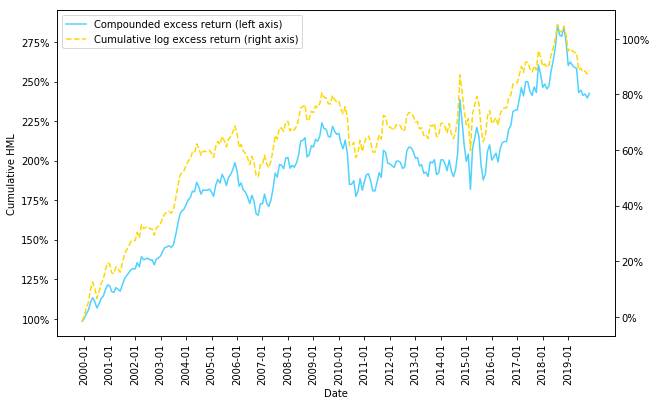

In [53]:
monthly['rt'] = monthly.groupby(['code'])['rt'].shift(-1)
monthly['mktcap'] = monthly['mktcap']*100000000
alldata = pd.merge(monthly,bm2,on = ['code','month_num'])
alldata['size'] = size = np.log(alldata['mktcap'])

def get_decile(data,x1_name,x2_name):
    x1 = data.groupby(['date'])[x1_name].describe(percentiles=[0.3, 0.7]).reset_index() 
    x1 = x1[['date','30%','70%']]
    x2 = data.groupby(['date'])[x2_name].describe(percentiles=[0.5]).reset_index()
    x2 = x2[['date','50%']]
    df = pd.merge(x1, x2, how='inner', on=['date'])
    df.columns=['date','B1_1t','B1_2t','B2_1t']   
    return df

decile = get_decile(alldata,'bm','size')

def portfolio_ind_3x4(breakpoints,X1_name,X2_name):
    data = alldata.copy()
    date = data[['date']].drop_duplicates()
    X = pd.DataFrame()
    for t in date['date']:
        temp_data = data[data['date'] == t]
        temp_breakpoint = breakpoints[breakpoints['date'] == t].iloc[0,:]
        B1 = [-np.inf,temp_breakpoint[1],temp_breakpoint[2],np.inf]
        B2 = [-np.inf,temp_breakpoint[3],np.inf]
        temp = pd.DataFrame()
        for i in range(3):
            x = temp_data[(temp_data[X1_name]>=B1[i])&(temp_data[X1_name]<=B1[i+1])]
            x['bmport'] = X1_name+str(i+1)
            temp = pd.concat([temp,x])
        temp2 = pd.DataFrame()
        for j in range(2):
            x = temp[(temp[X2_name]>=B2[j])&(temp[X2_name]<=B2[j+1])]
            x['szport'] = X2_name+str(j+1)
            temp2 = pd.concat([temp2,x])
        X = pd.concat([X,temp2])
    return X

class_1 = portfolio_ind_3x4(decile,'bm','size')

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

vwret=class_1.groupby(['date','szport','bmport']).apply(wavg,'rt','mktcap').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret['sbport']=vwret['szport']+vwret['bmport']
ff_factors=vwret.pivot(index='date', columns='sbport', values='vwret').reset_index()


# create SMB and HML factors
ff_factors['WH']=(ff_factors['size2bm3']+ff_factors['size1bm3'])/2
ff_factors['WL']=(ff_factors['size2bm1']+ff_factors['size1bm1'])/2
ff_factors['WHML'] = ff_factors['WH']-ff_factors['WL']

ff_factors['1+rt'] = ff_factors['WHML']+1
ff_factors['ln1+rt'] = np.log(ff_factors['1+rt'])
ff_factors['cer'] = ff_factors['1+rt'].cumprod()
ff_factors['cler'] = ff_factors['ln1+rt'].cumsum()

def plot(data,key1,key2):
    data = data.set_index('date')
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(111)
    lns1 = ax1.plot(data[key1]*100, '-',color='deepskyblue',alpha=0.7, label = 'Compounded excess return (left axis)')
    plt.xticks(rotation=90)
    ax2 = ax1.twinx()
    lns2 = ax2.plot(data[key2]*100, '--',color='gold',label = 'Cumulative log excess return (right axis)')
    lns = lns1+lns2
    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
    plt.xticks(pd.date_range('2000-1','2019-12',freq='12M'))#时间间隔
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)
    fmt='%.0f%%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax1.yaxis.set_major_formatter(yticks)
    ax2.yaxis.set_major_formatter(yticks)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative HML')
    return fig

fig1 = plot(ff_factors,'cer','cler')

## 10.7FF三因子模型

前面第7和第9章分别提供了MKT和SMB因子，加上本章的HML因子，构成了FF三因子的模型。Fama和French提出，这三个变量分别代表三个风险因子。当我们想检验投资组合是否产生了不被这三种因子解释或者说不由这三种原因引起的超额收益时，将投资组合的时序超额收益与三个因子值带常数项α进行回归，回归中三个因子的系数代表了投资组合对相对风险因素的敏感性。而当常数项α显著不为0时，说明投资组合的超额收益不能完全被三个因子解释。

## 10.8总结

本章验证了BM与股票收益率间的关系，即使在控制beta和MktCap后这样的关系基本仍存在。